In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import plotly.express as px

In [2]:
df = pd.read_csv('Data/basketball_stats.csv')

In [3]:
cols_dict = {
    'GP': 'Games_Played',
    'MIN': 'Minutes_Played',
    'FGM': 'Field_Goals_Made',
    'FGA': 'Field_Goals_Attempts',
    '3PM': 'Three_Points_Made',
    '3PA': 'Three_Points_Attempts',
    'FTM': 'Free_Throws_Made',
    'FTA': 'Free_Throws_Attempts',
    'TOV': 'Turnovers',
    'PF': 'Personal_Fouls',
    'ORB': 'Offensive_Rebounds',
    'DRB': 'Defensive_Rebounds',
    'REB': 'Rebounds',
    'AST': 'Assists',
    'STL': 'Steals',
    'BLK': 'Blocks',
    'PTS': 'Points' 
}

In [4]:
df = df.rename(columns = cols_dict)

In [5]:
nba = df.query('League == "NBA"')

## Overview Stages

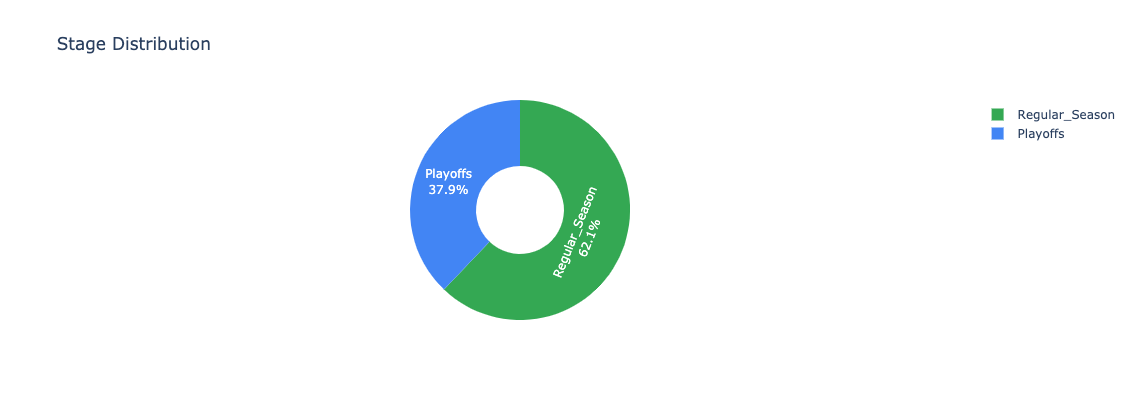

In [6]:
values=nba['Stage'].value_counts().values
labels=nba['Stage'].value_counts().index
fig = px.pie(nba, values=values, names=labels,
             color=labels,
             color_discrete_map={'Regular_Season': '#34A853', 'Playoffs':'#4285F4'}, 
             height=400,
             title='Stage Distribution', 
             hole=.4,
             hover_name=labels
            )
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(legend_itemclick="toggleothers")
fig.show()

## 

## Stages and Points

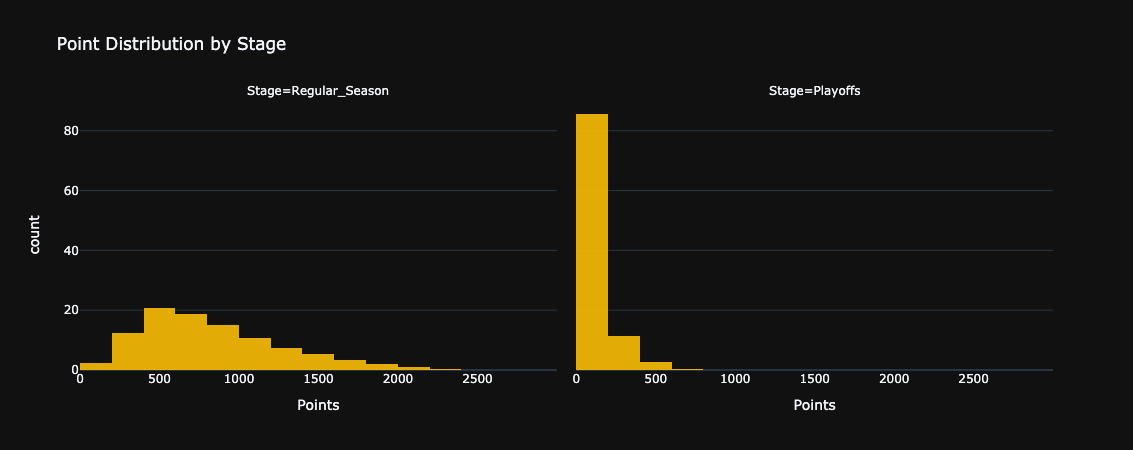

In [7]:
temp = 'plotly_dark'
fig = px.histogram(nba, x='Points', facet_col='Stage',
                   nbins=20, histnorm='percent',
                   color_discrete_sequence=['#FBBC05'],
                   opacity=0.9,
                   title='Point Distribution by Stage', 
                   template=temp
                  )

fig.show()

## Season AVG Points Scored By All Players

* These are the points scored by players - That is the reason why the number is so high

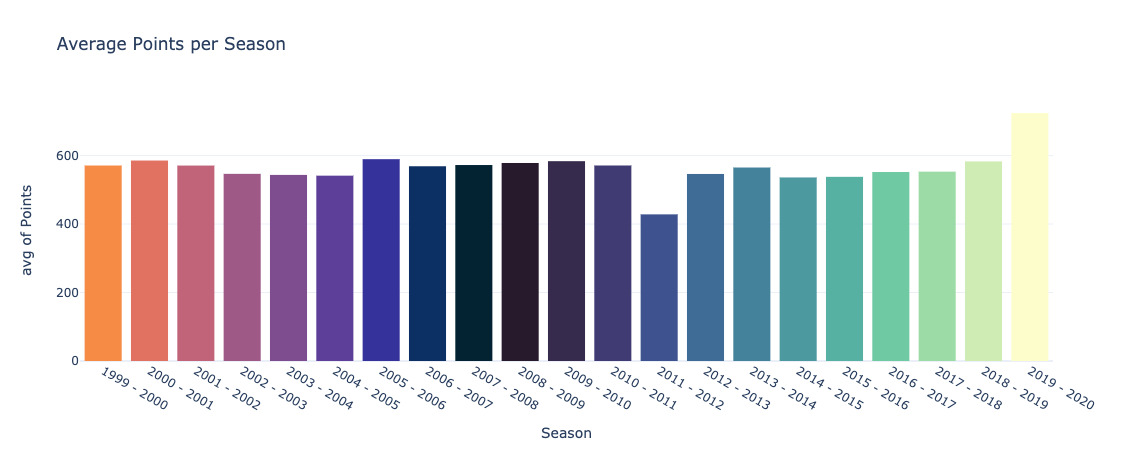

In [8]:
farben=px.colors.sequential.deep+px.colors.sequential.thermal

temp='plotly_white'
fig = px.histogram(
    nba, 
    x='Season',
    y='Points',
    color='Season',
    color_discrete_sequence=farben,
    histfunc='avg',
    title='Average Points per Season',
    template=temp
)
fig.update_xaxes(categoryorder='category ascending')
fig.update_layout(showlegend=False)
fig.show()

# Top 10 Players

## a) Total Points

In [9]:
point_leaders = nba.groupby('Player').sum().sort_values(by='Points', ascending=False).head(10).reset_index()

In [10]:
point_leaders = point_leaders.drop(['weight_kg', 'weight', 'height_cm', 'birth_year'], axis=1)

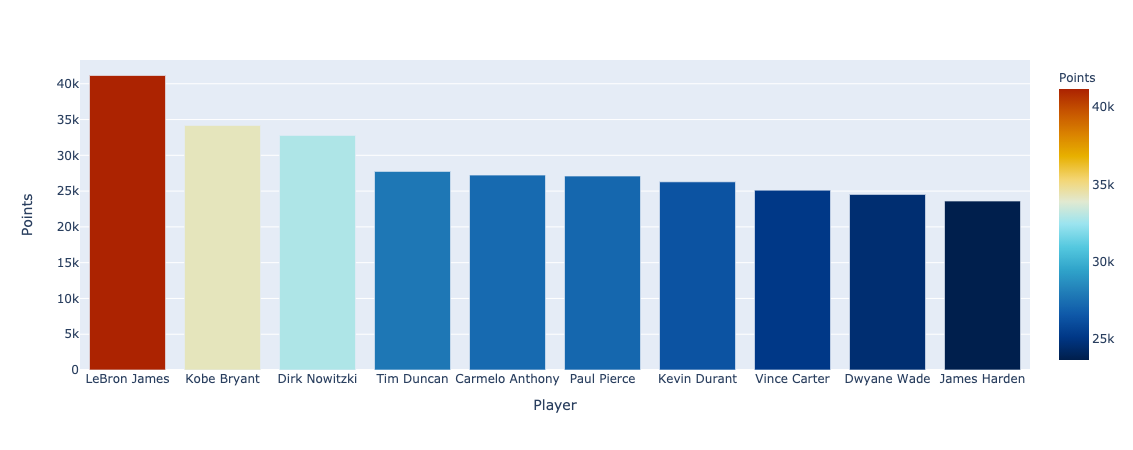

In [11]:
fig=px.bar(
    point_leaders, 
    x='Player', 
    y='Points', 
    color='Points',
    color_continuous_scale=px.colors.cyclical.IceFire[1:-3]
)
fig.show()

## b) Points vs. Attempts

In [12]:
def add_cols(df, *args):
    cols_range = range(1, len(list(args)))
    col_list = [col for col in args]
    base_col = df[col_list[0]].copy()

    for i in cols_range:
        base_col += df[col_list[i]]
    return base_col

In [13]:
point_leaders['Total_Attempts'] = add_cols(point_leaders, 'Field_Goals_Attempts', 'Three_Points_Attempts', 'Free_Throws_Attempts')

In [14]:
point_leaders['Total_Throws_Made'] = add_cols(point_leaders, 'Field_Goals_Made', 'Three_Points_Made', 'Free_Throws_Made')

In [15]:
point_leaders['Points_Attempt_Ratio'] = (point_leaders['Points']/point_leaders['Total_Attempts'])

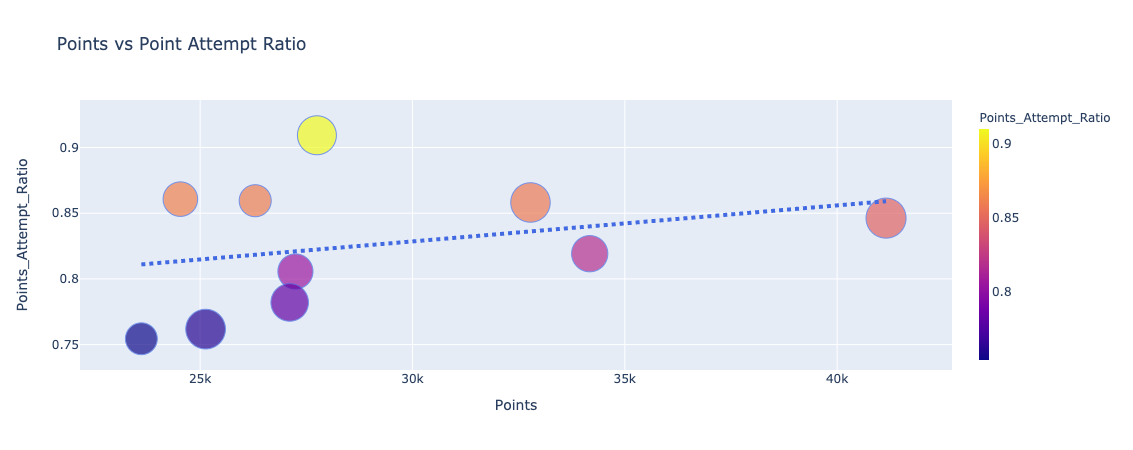

In [16]:
size=point_leaders['Games_Played']
fig = px.scatter(
    point_leaders, x='Points', y='Points_Attempt_Ratio',
    color='Points_Attempt_Ratio',
    color_discrete_sequence=px.colors.sequential.Rainbow,
    size=size, 
    hover_name='Player',
    title='Points vs Point Attempt Ratio',
    trendline='ols',
)
fig.update_traces(marker=dict(
    sizeref=2*max(size)/(40**2), 
    sizemode='area', 
    sizemin=0,
))
fig.update_layout(
    coloraxis_colorbar_thicknessmode='pixels',
    coloraxis_colorbar_thickness=10,
    #coloraxis_showscale=False
)
fig.update_traces(
    line_dash='dot',
    line_width=4,
    line_color='royalblue')

fig.show()

## c) Skill Profile (Line-Polar Viz)

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
min_max_scaler= MinMaxScaler()

In [19]:
skills = ['Rebounds', 'Assists', 'Steals', 'Blocks', 'Points']

In [20]:
player_profile = nba.groupby('Player').sum().sort_values(by='Points', ascending=False).reset_index()

In [21]:
normalized_skills = min_max_scaler.fit_transform(player_profile[skills])

In [22]:
normalized_skills_df = pd.DataFrame(normalized_skills, columns=player_profile[skills].columns)
normalized_skills_df = normalized_skills_df.add_suffix('_Normalized')

In [23]:
player_skills = pd.concat([player_profile.loc[:,['Player', 'Points']], normalized_skills_df], axis=1)

In [24]:
player_skills = player_skills.sort_values(by='Points', ascending=False).head(10)
player_skills = player_skills.drop('Points', axis=1)

In [25]:
polar_df = pd.melt(player_skills, id_vars=['Player'], value_vars=player_skills.drop('Player', axis=1).columns, var_name='Skills')

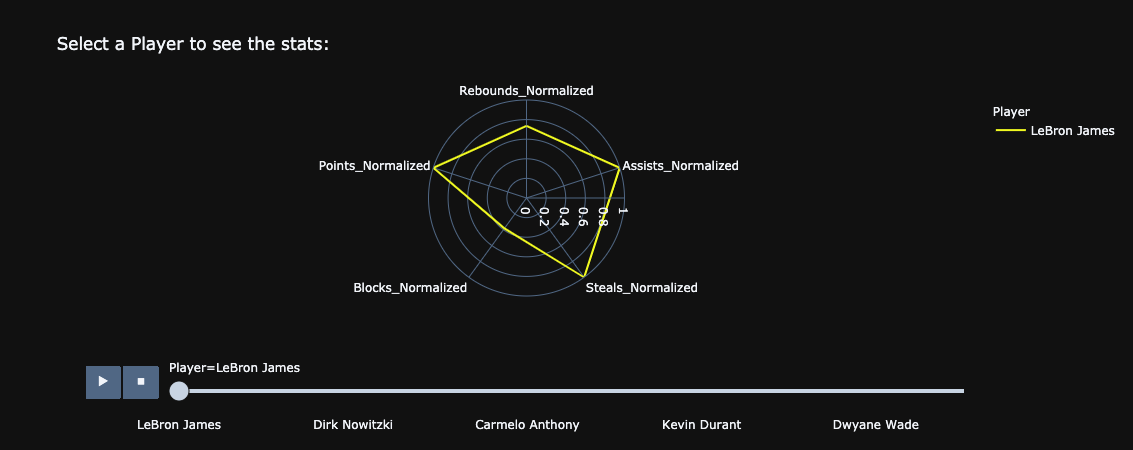

In [26]:
fig = px.line_polar(polar_df, r="value", theta="Skills", color='Player', line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark", 
                    animation_frame="Player",
                    animation_group="Player",
                    title='Select a Player to see the stats:'
                   )
fig.show()

## d) Skill Profile (Bar-Polar Viz)

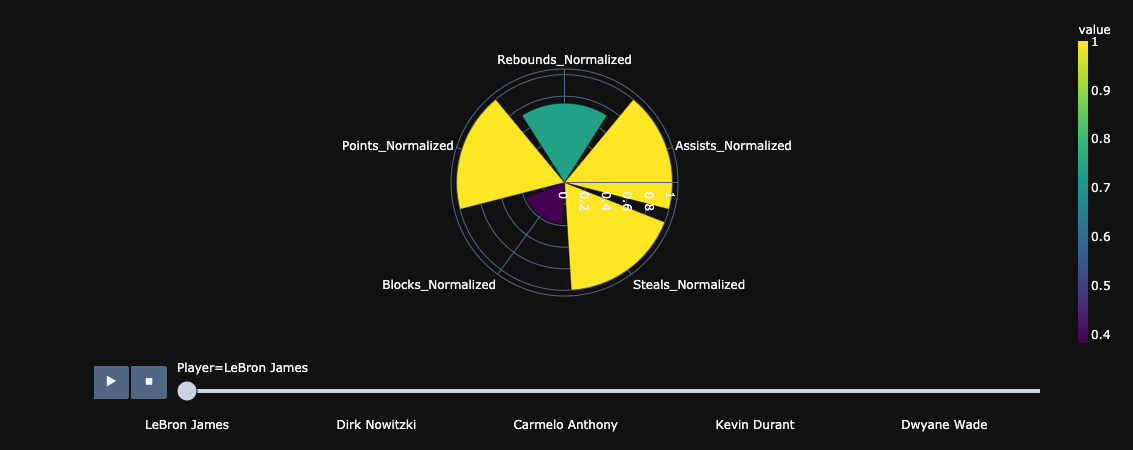

In [27]:
fig = px.bar_polar(polar_df, r="value", theta="Skills", color='value',
                    color_continuous_scale=px.colors.sequential.Viridis,
                    animation_frame="Player",
                    animation_group="Player",
                    template="plotly_dark", 
                    title='')
fig.update_layout(
    coloraxis_colorbar_thicknessmode='pixels',
    coloraxis_colorbar_thickness=10,
    coloraxis_colorbar_len=1.5
)
fig.show()

## Height Distribution

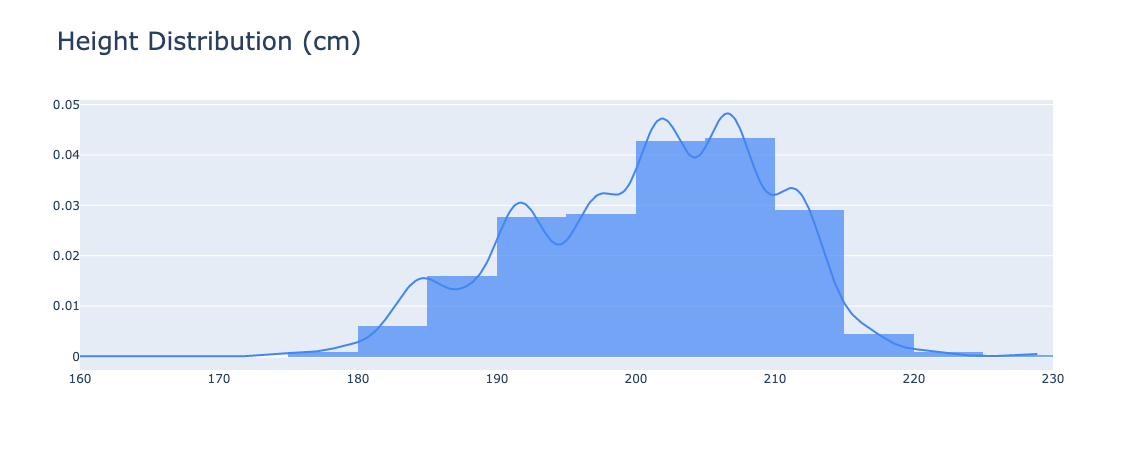

In [28]:
import plotly.figure_factory as ff
hist_data = [nba['height_cm']]
group_labels = ['Height Distribution'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, 
                         show_rug=False, colors=['#4285F4'],
                         bin_size=5.0)
fig.update_layout(title_text='Height Distribution (cm)', 
                  title_font_size=25, showlegend=False)
fig.show()

## Number of Blocks by Height

In [29]:
high_light = point_leaders['Player'].to_list()

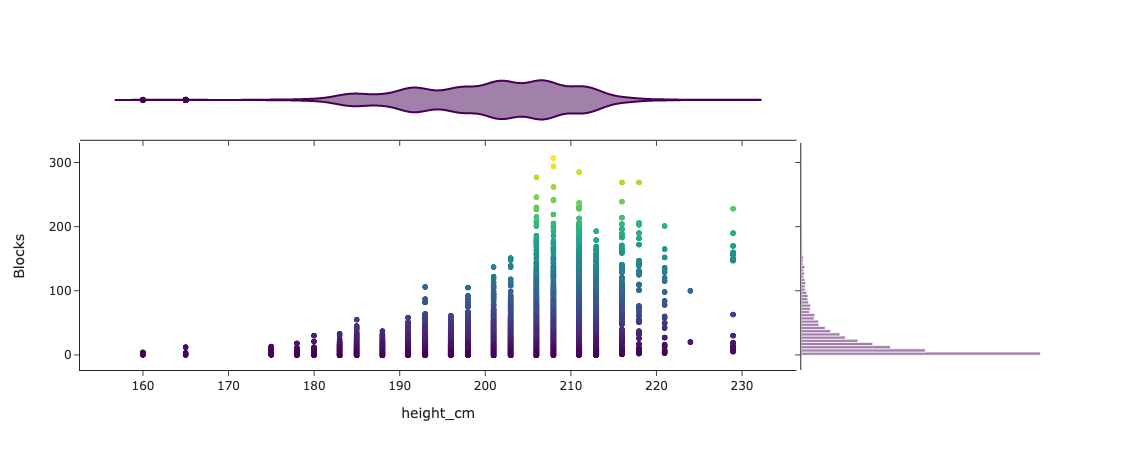

In [30]:
temp = 'simple_white'
fig = px.scatter(nba, x='height_cm', y='Blocks', 
                 marginal_x='violin', marginal_y='histogram', 
                 hover_name='Player', 
                 color='Blocks', 
                 template=temp)

fig.update_layout(coloraxis_colorbar_len=0.75,
                  coloraxis_colorbar_thickness=20,
                  coloraxis_colorbar_y=0.4,
                  hoverlabel_bgcolor="white", 
                  hoverlabel_font_size=16, 
                  hoverlabel_font_family="Rockwell",
                  coloraxis_showscale=False)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Players Count by Highschool

In [31]:
player_school_df = df.groupby(['Player', 'high_school']).sum().reset_index()

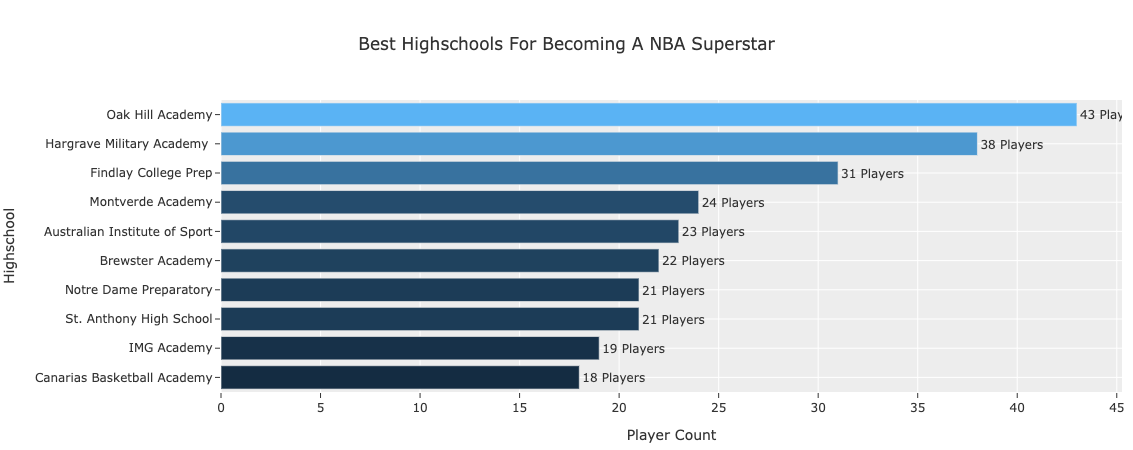

In [32]:
temp = 'ggplot2'
labels_hnames = player_school_df['high_school'].value_counts().head(10).index
values_hcount = player_school_df['high_school'].value_counts().head(10).values
bar_label = [str(val) + ' Players' for val in values_hcount]

fig = px.bar(player_school_df, x=values_hcount, y=labels_hnames, 
             orientation='h',
             color=values_hcount,
             hover_name=labels_hnames,
             text=bar_label, title='Best Highschools For Becoming A NBA Superstar', template=temp)

fig.update_traces(textposition='outside')
fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(coloraxis_showscale=False, 
                  xaxis_title_text='Player Count', 
                  yaxis_title_text='Highschool',
                  margin=dict(l=20, r=10, b=20))
fig.show()

## Worst Stats From Players with more than 100 Games

In [33]:
# Negative stats cols: Turnovers, Personal_Fouls,
neg_stats_df = nba.copy()

In [34]:
neg_stats_df=neg_stats_df.groupby(['Player'])[['Games_Played', 'Turnovers', 'Personal_Fouls']].sum().reset_index()

In [35]:
neg_stats_df = neg_stats_df.query("Games_Played > 100")

In [36]:
neg_stats_df['Neg_score'] = add_cols(neg_stats_df, 'Personal_Fouls', 'Turnovers')

In [37]:
neg_stats_df['Neg_score_per_game'] = (neg_stats_df['Neg_score']/neg_stats_df['Games_Played']).round(2)

In [38]:
highest_neg_score = neg_stats_df.sort_values('Neg_score_per_game', ascending=False).head(10)

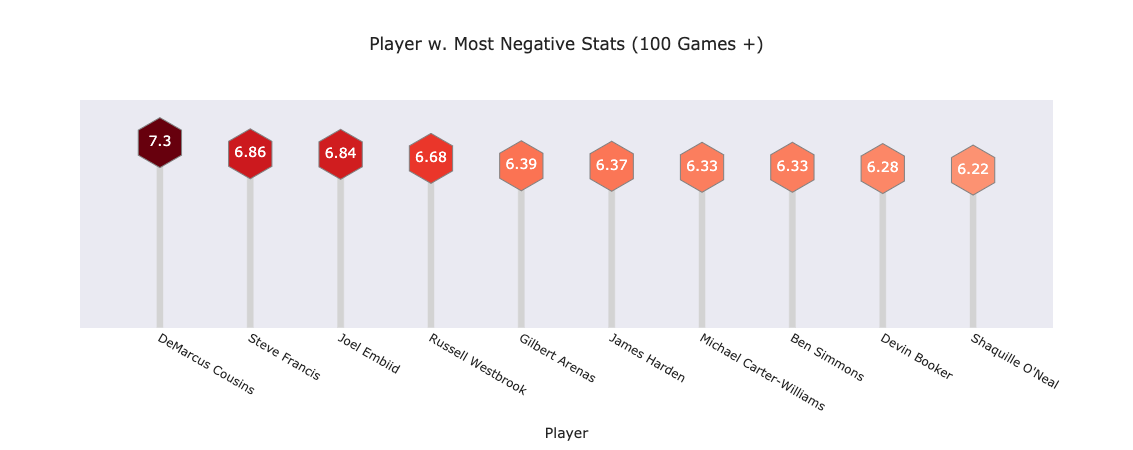

In [39]:
temp='seaborn'
fig = px.scatter(highest_neg_score, y='Neg_score_per_game', x='Player', 
                 text='Neg_score_per_game',
                 color='Neg_score_per_game',
                 color_continuous_scale= px.colors.sequential.Reds[3:],    
                 hover_name='Player', 
                 hover_data=['Games_Played', 'Turnovers', 'Personal_Fouls'], title='Player w. Most Negative Stats (100 Games +)', 
                 template=temp)

fig.update_traces(marker_size=50, marker_line_color='grey', marker_line_width=1, marker_symbol='hexagon', 
                  textfont_size=14, textfont_color='white')

fig.add_bar(x=highest_neg_score['Player'], y=highest_neg_score['Neg_score_per_game'], width=0.08, marker_color='lightgrey')

fig.update_layout(coloraxis_showscale=False, showlegend=False)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, visible=False)
fig.show()

# Season Overview - Table & Dropdown Graphs

In [40]:
agg_dict = dict(
    Turnovers = 'sum', 
    Rebounds = 'sum', 
    Assists = 'sum', 
    Steals = 'sum', 
    Blocks = 'sum', 
    Points = 'sum')


In [41]:
season = nba.groupby(['Season']).agg(agg_dict).reset_index()

In [42]:
season_table = season.copy()

In [43]:
filt = [cname for cname in season_table.columns if season_table[cname].dtypes !='object']

In [44]:
season_table[filt] = (season_table[filt]//1000).astype(str)+'K'

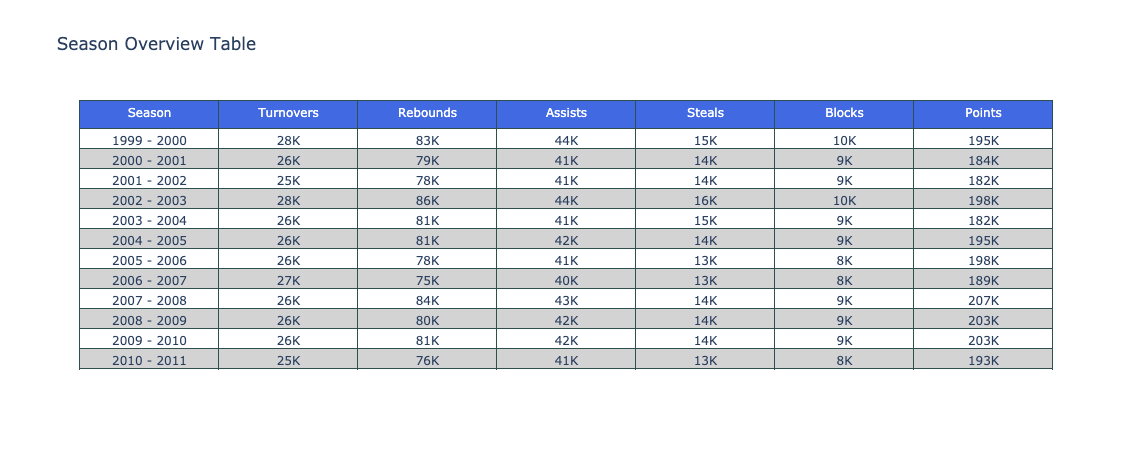

In [45]:
import plotly.graph_objects as go
fig = go.Figure(
    go.Table(
        header=dict(values=list(season_table.columns),
                fill_color='royalblue',
                line_color='darkslategray',
                align='center', font_size=12, font_color='white'),
        cells=dict(values=[season_table[cname] for cname in season_table.columns],
               fill_color = [['white','lightgrey']*len(season)],
               line_color='darkslategray',
               align='center')
    )
)
fig.update_layout(title='Season Overview Table')
fig.show()

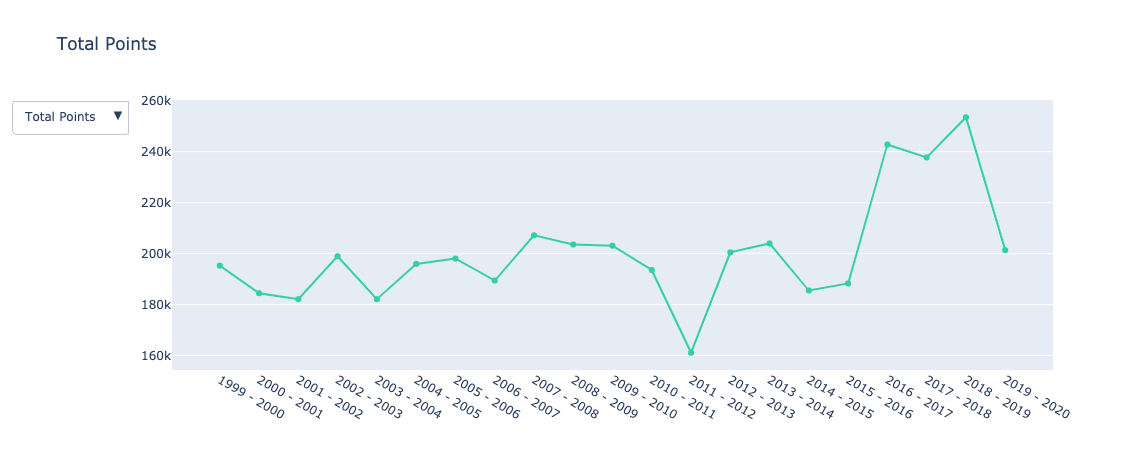

In [46]:
fig = go.Figure()
# Add Traces (Graphs)
fig.add_traces(
    go.Scatter(
        x=season['Season'],
        y=season['Points'],
        mode='lines+markers',
        line_color='#33CFA5',
        name='Total Points'
    )
)

fig.add_traces(
    go.Scatter(
        x=season['Season'],
        y=season['Blocks'],
        mode='lines+markers',
        name='Total Blocks',
        line_color='#F06A6A',
        visible=False,
    )
)

fig.add_traces(
    go.Bar(
        x=season['Season'],
        y=season['Assists'],
        name='Total Assists',
        marker_color=season['Assists'],
        marker_colorscale= px.colors.diverging.delta[:11],
        # season_table is the DataFrame I have created to display the table above
        text=season_table['Assists'],
        textposition='auto',
        visible=False,
    )
)

fig.add_traces(
    go.Scatter(
        x=season['Season'],
        y=season['Steals'],
        fill='toself',
        name='Total Steals',
        line_color='#4285F4',
        visible=False
    )
)
fig.update_layout(
    updatemenus=[
        dict(
            active=1, 
            buttons=list([
                dict(
                    label='All',
                    method='update',
                    args=[{'visible': [True, True, True, True]}, {'title': 'All'}]),
                dict(
                    label='Total Points',
                    method='update',
                    args=[{'visible': [True, False, False, False]}, {'title': 'Points per Season'}]),
                dict(
                    label='Total Blocks', 
                    method='update', 
                    args=[{'visible':[False, True, False, False]}, {'title': 'Blocks per Season'}]),
                dict(
                    label='Total Assists', 
                    method='update', 
                    args=[{'visible': [False, False, True, False]}, {'title': 'Assists per Season'}]),
                dict(
                    label='Total Steals', 
                    method='update', 
                    args=[{'visible': [False, False, False, True]}, {'title': 'Steals per Season'}])
            ])
        )
    ]
)

# Set title for default view
fig.update_layout(title_text='Total Points')

fig.show()

# Teams, Seasons & Points

In [47]:
heat = nba.groupby(['Season', 'Team']).sum().reset_index()

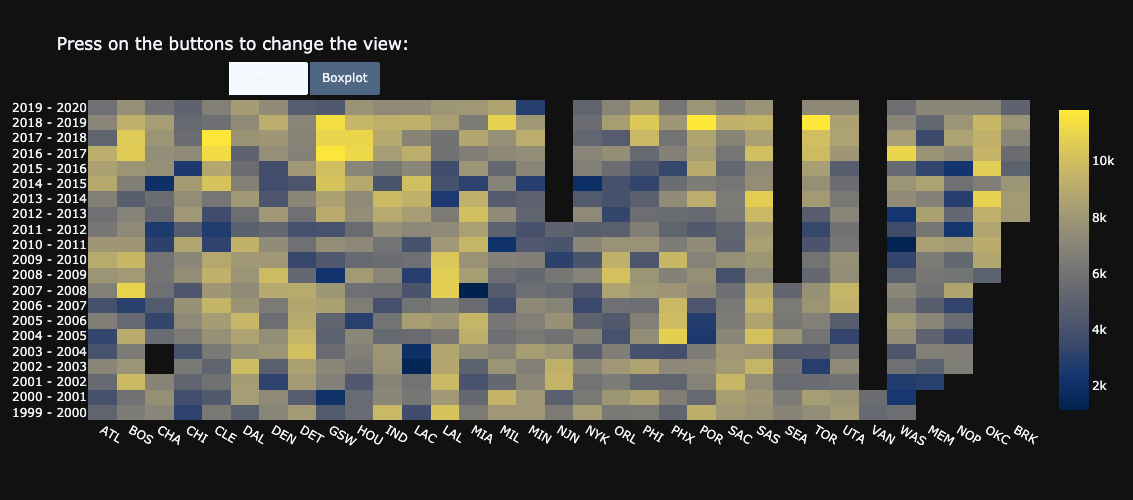

In [48]:
fig=go.Figure()

fig.add_traces(
    go.Heatmap(
        z=heat['Points'],
        x=heat['Team'],
        y=heat['Season'],
        colorscale=px.colors.sequential.Cividis,
        hovertemplate ='<b>Team: %{y}</b><br>'+'<b>Team: %{x}</b><br>'+'<b>Points: %{z:.0f}</b><br>',
        hoverongaps=False, 
        visible=True
    )
)
fig.add_traces(
    go.Box(
        x=heat['Team'],
        y=heat['Points'],
        whiskerwidth=0.3,
        marker_color='#34A853',
        marker_size=4,
        line_width=1,
        visible=False
    )
)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(
                    label='Heatmap',
                    method='update',
                    args=[{'z': [heat['Points'], 'undefined'], 'x': [heat['Team'], 'undefined'], 'y': [heat['Season'], 'undefined'],
                           'visible': [True, False]}, 
                          {'title': 'Players Total Points by Season and Team'}]
                    ),
                dict(
                    label='Boxplot',
                    method='update',
                    args=[{'x': ['undefined', heat['Team']], 'y': ['undefined', heat['Points']], 'visible': [False, True]}, 
                          {'title': 'Total Players Points by Team'}]
                    )
                ]),
             type = 'buttons',
             direction='left',
             showactive=True,
             x=0.15,
             xanchor='left',
             y=1.12,
             yanchor='top'
            )
    ]
)


fig.update_layout(template='plotly_dark', 
                  height=500, 
                  margin=dict(l=40, r=40, b=80, t=100),
                 )
fig.update_xaxes(showgrid=False, tickangle=30)
fig.update_yaxes(showgrid=False)

# Default Title
fig.update_layout(title_text='Press on the buttons to change the view:')

fig.show()

# Birth Count

In [49]:
players_birth=nba.groupby(['Player', 'birth_year', 'birth_month']).sum().reset_index()

In [50]:
birth_count=players_birth.groupby(['birth_year', 'birth_month']).agg({'Player': 'count'}).reset_index()

In [51]:
hoverinfo_birth=players_birth.groupby(['birth_year', 'birth_month'])['Player'].apply(list).reset_index(name='Players_List')

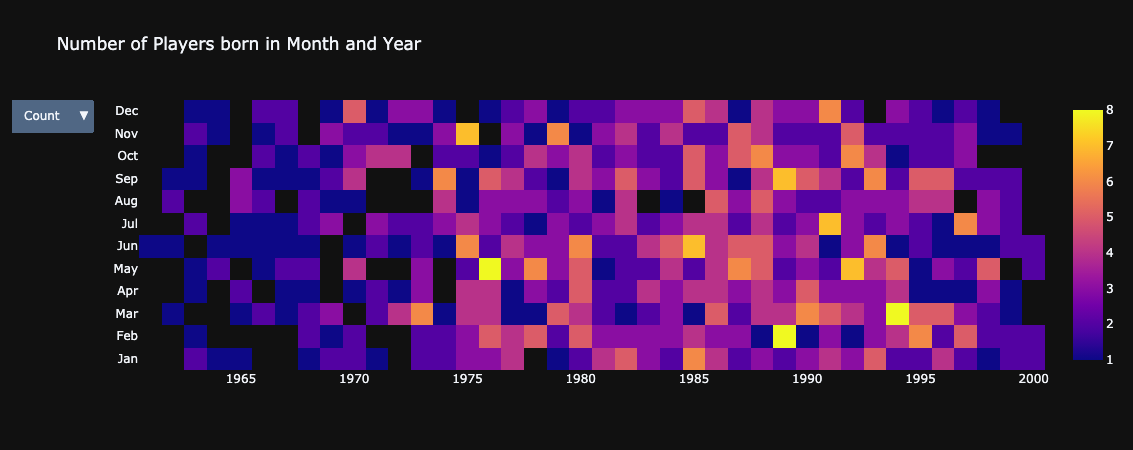

In [52]:
order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig=go.Figure()
fig.add_trace(
    go.Heatmap(
        z=birth_count['Player'],
        x=birth_count['birth_year'],
        y=birth_count['birth_month'],
        hovertemplate='<b>Year:</b> %{x}<br>'+'<b>Month:</b> %{y}<br>'+'<b>Players Count:</b> %{z}',
        hoverongaps=False,
        visible=True
    )
)

fig.add_trace(
    go.Heatmap(
        z=birth_count['Player'],
        x=hoverinfo_birth['birth_year'],
        y=hoverinfo_birth['birth_month'],
        hovertext=hoverinfo_birth['Players_List'],
        hovertemplate='<b>Year:</b> %{x}<br>'+'<b>Month:</b> %{y}<br>'+'<b>Player(s):</b> %{hovertext}',
        colorscale='Viridis',
        hoverongaps=False,
        visible=False
    )
)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(
                    label='Count',
                    method='update',
                    args=[{'visible':[True, False]}, {'title': 'Number of Players born in Month and Year'}]
                ),
                dict(
                    label='Details',
                    method='update',
                    args=[{'visible':[False, True]}, {'title': 'Player names born in Month and Year'}]
                )
            ])
        )
    ]
)
fig.update_layout(template='plotly_dark', title_text='Number of Players born in Month and Year')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, categoryarray=order)

fig.show()

# Highest Free Throw Ratio

* Compute average games played by player
* Only include player with equal or more than average games played

In [53]:
num_games = nba.groupby('Player')[['Games_Played']].sum().reset_index()

In [54]:
avg_games = num_games['Games_Played'].mean()

In [55]:
free_throw = nba.groupby(['Player', 'nationality', 'birth_year'])[[ 'Games_Played','Free_Throws_Attempts', 'Free_Throws_Made']].sum().reset_index()

In [56]:
filt=(free_throw['Free_Throws_Attempts']>0)&(free_throw['Free_Throws_Made']>0)&(free_throw['Games_Played']>avg_games)
free_throw = free_throw.loc[filt]

In [57]:
free_throw['Free_Throw_Ratio'] = (free_throw['Free_Throws_Attempts']/free_throw['Free_Throws_Made']).round(2)

In [58]:
free_throw = free_throw.sort_values(by='Free_Throw_Ratio', ascending=False).head(10)

In [59]:
free_throw['birth_year'] = free_throw['birth_year'].astype(int)

In [60]:
free_throw['rank'] = free_throw['Free_Throw_Ratio'].rank(method='max', ascending=False).astype(int)

In [61]:
free_throw['rank'] = free_throw['rank'].astype(str)+'. Place'

In [62]:
test = free_throw.melt(id_vars=['Player', 'nationality', 'Free_Throw_Ratio', 'rank'])

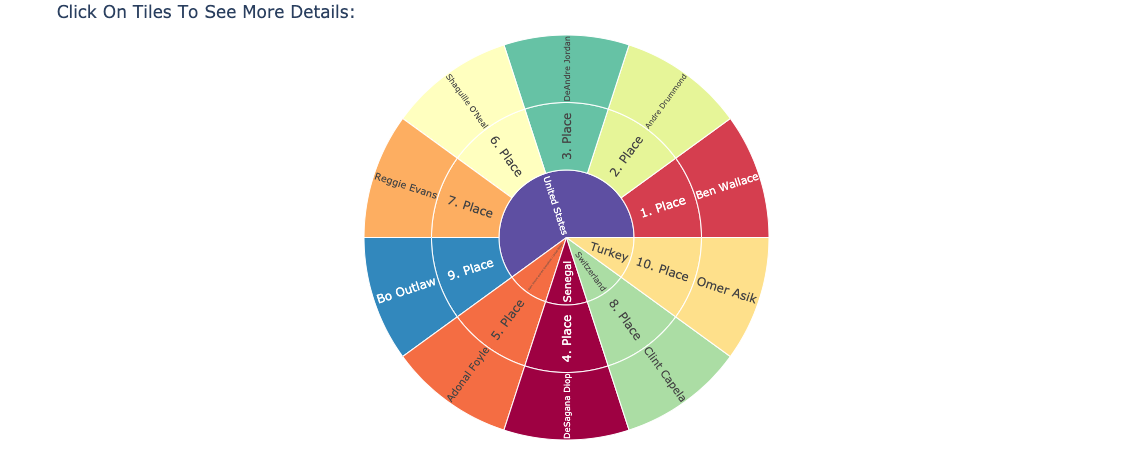

In [63]:
fig = px.sunburst(test, path=['nationality', 'rank','Player', 'variable', 'value'],
                  color='rank', color_discrete_sequence=px.colors.diverging.Spectral, 
                  title='Click On Tiles To See More Details:')

fig.update_traces(insidetextorientation='radial', maxdepth=3, hovertemplate=None, hoverinfo='skip')

fig.update_layout(
    margin = dict(t=35, l=10, r=10, b=10)
)

#fig.show(renderer='browser')
fig.show()

# Playoffs 17/18 vs. 18/19

In [64]:
latest_filt=(nba['Season']=='2018 - 2019') & (nba['Stage']=='Playoffs')
prior_filt=(nba['Season']=='2017 - 2018') & (nba['Stage']=='Playoffs')
df_latest=nba.loc[latest_filt]
df_prior=nba.loc[prior_filt]

In [65]:
lt=df_latest.groupby('Team').agg({'Games_Played': 'max', 'Points': 'sum'}).reset_index()

In [66]:
lt=lt.round(2)

In [67]:
pr=df_prior.groupby('Team').agg({'Games_Played': 'max', 'Points': 'sum'}).reset_index()

In [68]:
pr=pr.round(2)

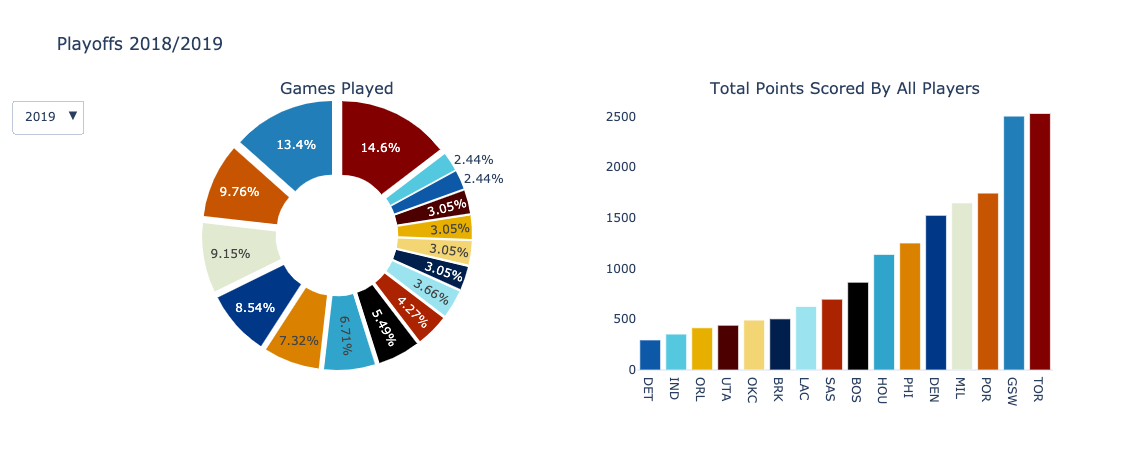

In [69]:
from plotly.subplots import make_subplots
fig=make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "xy"}]], 
                  subplot_titles=("Games Played", "Total Points Scored By All Players"))

fig.add_pie(row=1, col=1,
    values=lt['Games_Played'], 
    labels=lt['Team'], 
    pull=0.1,
    hole=0.4,
    marker_colors=px.colors.cyclical.IceFire[:-1],
    visible=True
)

fig.add_bar(row=1, col=2,
    y=lt['Points'], 
    x=lt['Team'],
    marker_coloraxis='coloraxis',
    marker_color=px.colors.cyclical.IceFire[:-1],
    visible=True
)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(
                    label='2019',
                    method='update',
                    args=[{'values': [lt['Games_Played'], 'lt_2019'], 'y': ['lt_2019', lt['Points']], 'visible': [True, True]}, 
                          {'title': 'Playoffs 2018/2019'}]
                ),
                dict(
                    label='2018',
                    method='update',
                    args=[{'values': [pr['Games_Played'], 'pr_2018'], 'y': ['pr_2018', pr['Points']], 'visible': [True, True]}, 
                          {'title': 'Playoffs 2017/2018'}]
                )
                
            ])
        )
    ]
)

fig.update_layout(showlegend=False, title_text='Playoffs 2018/2019', template='plotly_white')
fig.update_xaxes(categoryorder='total ascending')
fig.update_yaxes(categoryorder='total ascending', showgrid=False)
fig.show()

# Top 50 Player Word Cloud

In [70]:
word_cloud=nba.groupby(['Player'])['Games_Played'].sum().reset_index()

In [71]:
# Create 148 colors
import matplotlib

hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)

#print(hex_colors_only)

# getting random color from list of hex colors

#print(random.choice(hex_colors_only))

In [72]:
word_cloud = word_cloud.sort_values(by='Games_Played', ascending=False).head(50).reset_index(drop=True)

In [73]:
from sklearn.preprocessing import MinMaxScaler
mmscaler= MinMaxScaler(feature_range=(10,18))
games_scaled=mmscaler.fit_transform(word_cloud[['Games_Played']])
df_games_scaled=pd.DataFrame(games_scaled,columns=['Normed_Games'])

In [74]:
word_cloud_scaled=pd.concat([word_cloud, df_games_scaled], axis=1)

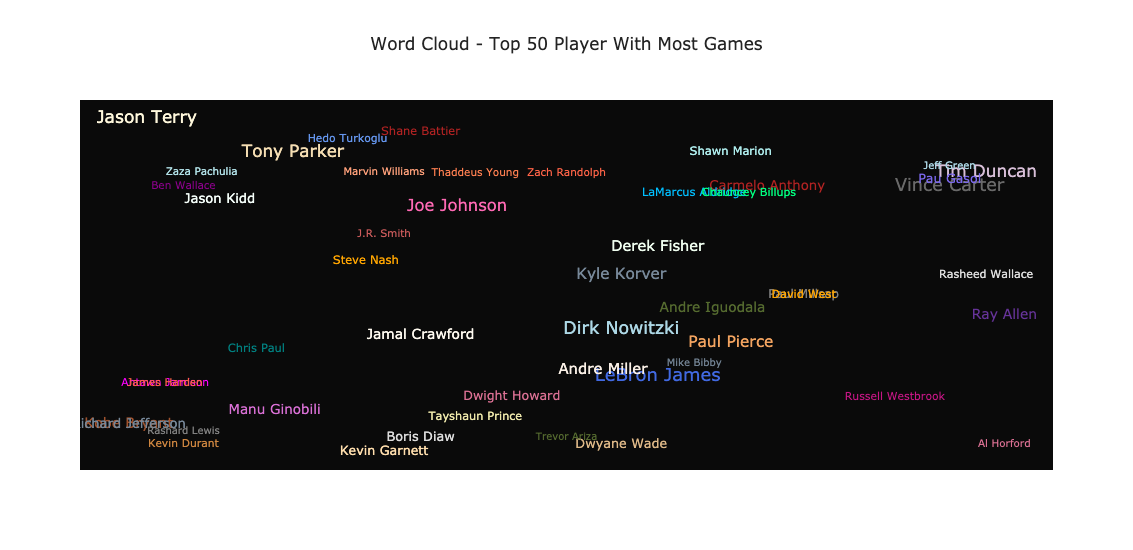

In [75]:
words=word_cloud_scaled['Player']
weight_size=word_cloud_scaled['Normed_Games']
num_words=len(words)
#colors=[px.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(num_words)]
# Use seed for reproducibility
np.random.seed(92)
colors=np.random.choice(hex_colors_only, num_words)
fig=go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.random.choice(range(num_words), num_words),
        y=np.random.choice(range(num_words), num_words),
        mode='text',
        text=words,
        marker_opacity=0.6,
        textfont_size=weight_size,
        textfont_color=colors, 
        hovertext=word_cloud_scaled['Games_Played'],
        hovertemplate='<b>Player:</b> %{text}<br>'+'<b>Games Played:</b> %{hovertext}',
    )
)


fig.update_layout(template='seaborn', 
                  title_text='Word Cloud - Top 50 Player With Most Games', 
                  plot_bgcolor='rgb(10,10,10)', 
                  height=550)
fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False)
fig.update_yaxes(showgrid=False,zeroline=False, showticklabels=False)
config = dict({'scrollZoom': True})
fig.show(config=config)

# Team Point Ratio

In [76]:
attempts=nba.groupby(['Team', 'Stage']).sum().reset_index()

In [77]:
# add_cols function defined above
attempts['Total_Attempts']=add_cols(attempts, 'Field_Goals_Attempts', 'Three_Points_Attempts', 'Free_Throws_Attempts')

In [78]:
attempts['Total_Scored']=add_cols(attempts, 'Field_Goals_Made', 'Three_Points_Made', 'Free_Throws_Made')

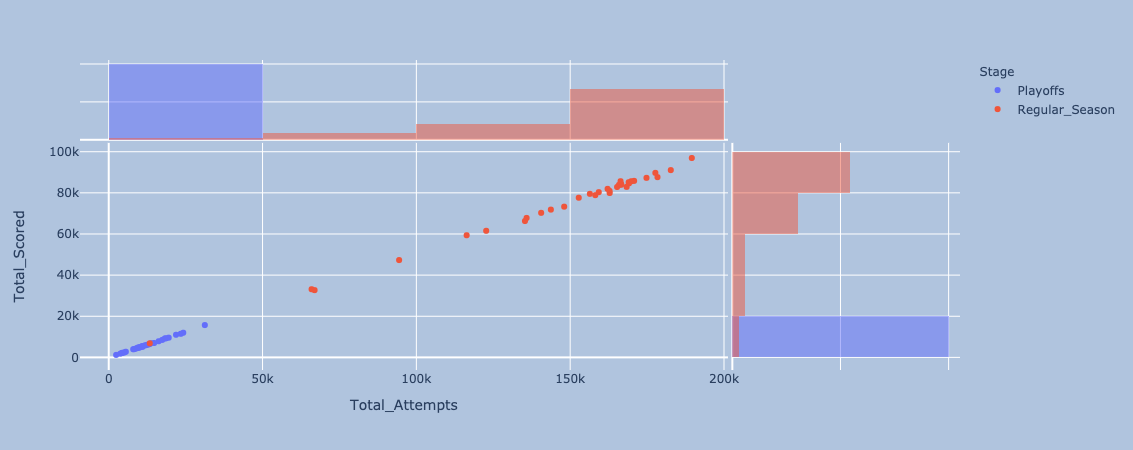

In [79]:
fig=px.scatter(
    attempts, x='Total_Attempts', 
    y='Total_Scored', 
    marginal_x='histogram', 
    marginal_y='histogram', 
    color='Stage', 
    hover_name='Team'
)

fig["layout"].pop("updatemenus")
fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.update_layout(
    paper_bgcolor="LightSteelBlue",
    plot_bgcolor='LightSteelBlue'
)

fig.show()

# Weight To Height Ratio

In [80]:
stage_filt=(nba['Stage']=='Regular_Season')

In [81]:
thick_df = nba.loc[stage_filt].groupby(['Team', 'Season'])[['height_cm', 'weight_kg']].sum().reset_index()

In [82]:
thick_df['wh_ratio']=(thick_df['weight_kg']/thick_df['height_cm']).round(3)

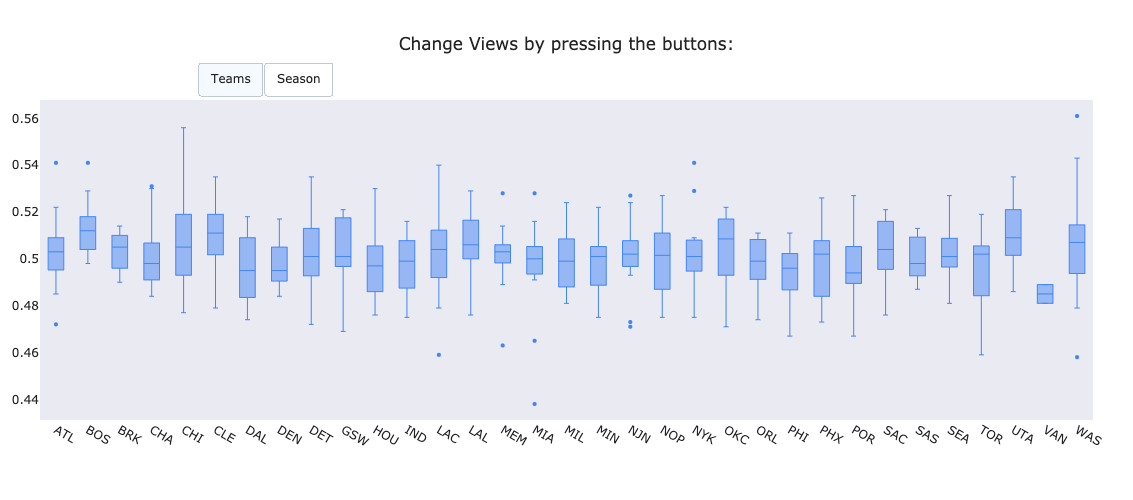

In [83]:
fig=go.Figure()

fig.add_traces(
    go.Box(
        x=list(thick_df['Team']),
        y=list(thick_df['wh_ratio']),
        whiskerwidth=0.3,
        marker_color='#4285F4',
        marker_size=4,
        line_width=1,
        visible=True,
    )
)
fig.add_traces(
    go.Scatter(
        x=list(thick_df['Season']),
        y=list(thick_df['wh_ratio']),
        text=list(thick_df['Team']),
        hovertemplate ='<b>Team: %{text}</b><br>'+'<b>Weight to Height Ratio: %{y:.3f}</b><br>',
        visible=False,
        marker_symbol='square',
        marker_size=20,
        marker_line_color='white', 
        marker_line_width=1,
        marker_color=list(thick_df['wh_ratio']),
        marker_colorscale=px.colors.sequential.Sunset,
        mode='markers'
    )
)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(
                    label='Teams',
                    method='update',
                    args=[{'visible': [True, False]}, {'title': 'Teams View'}]
                    ),
                dict(
                    label='Season',
                    method='update',
                    args=[{'visible': [False, True]}, {'title': 'Season View'}]
                    )
                ]),
             type = 'buttons',
             direction='left',
             showactive=True,
             x=0.15,
             xanchor='left',
             y=1.12,
             yanchor='top'
            )
    ]
)


fig.update_layout(template='seaborn',
                  height=500, 
                  margin=dict(l=40, r=40, b=80, t=100),
                 )
fig.update_xaxes(showgrid=False, tickangle=30)
fig.update_yaxes(showgrid=False)

# Default Title
fig.update_layout(title_text='Change Views by pressing the buttons:')

fig.show()

# Thickness Above Replacement (TAR)

* Formula: (Player's weight) - (Avg. weight at the player's height)
* This is simply the variance in weight between the average NBA player at each height 
* This shows each team's pounds above average
* This metric takes into account that taller players weight more

In [84]:
avg_weight_df=nba.groupby('height_cm')[['weight_kg']].mean().reset_index().round()

In [85]:
nba_temp=nba.loc[stage_filt]

In [86]:
temp_df=nba_temp.groupby(['Player', 'Season','Team']).sum().reset_index()

In [87]:
tar_df=temp_df.merge(avg_weight_df, left_on='height_cm', right_on='height_cm', how='left', suffixes=('', '_avg'))

In [88]:
tar_df['TAR']=tar_df['weight_kg']-tar_df['weight_kg_avg']

In [89]:
tar_df.head(2)

Player       Season Team  Games_Played  Minutes_Played  \
0  A.C. Green  1999 - 2000  LAL            82          1929.0   
1  A.C. Green  2000 - 2001  MIA            82          1411.0   

   Field_Goals_Made  Field_Goals_Attempts  Three_Points_Made  \
0               173                   387                  1   
1               144                   324                  0   

   Three_Points_Attempts  Free_Throws_Made  Free_Throws_Attempts  Turnovers  \
0                      4                66                    95         53   
1                      6                79                   111         45   

   Personal_Fouls  Offensive_Rebounds  Defensive_Rebounds  Rebounds  Assists  \
0             127                 160                 326       486       80   
1             119                 107                 206       313       39   

   Steals  Blocks  Points  birth_year  height_cm  weight  weight_kg  \
0      53      18     413      1963.0      206.0   220.0      100.0   
1      30       8     367      1963.0      206.0   220.0      100.0   

   weight_kg_avg  TAR  
0          107.0 -7.0  
1          107.0 -7.0

In [90]:
team_tar=tar_df.groupby(['Season', 'Team']).mean().reset_index()

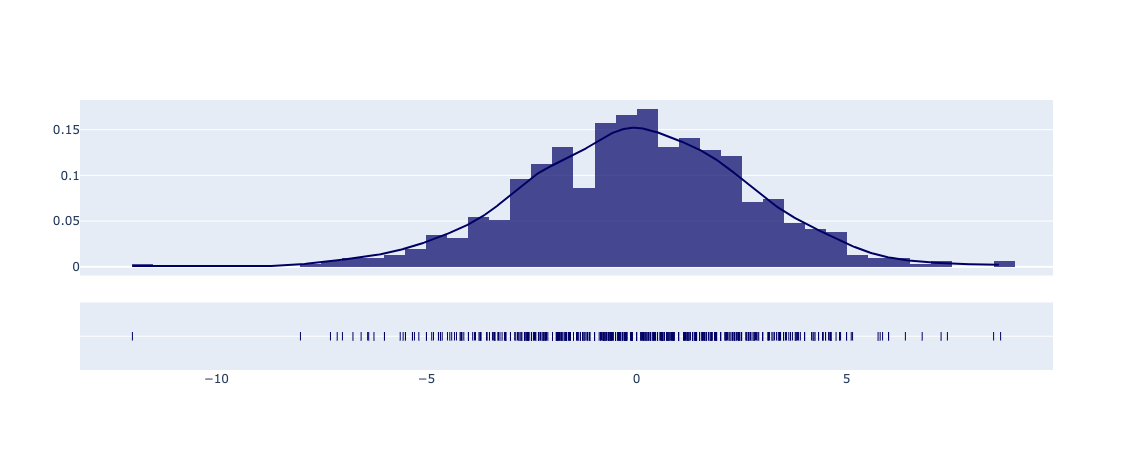

In [91]:
import plotly.figure_factory as ff

group_labels = ['Distplot']
colors=['rgb(0, 0, 100)']

fig=ff.create_distplot(
    [team_tar['TAR']], 
    group_labels,
    bin_size=.5,
    colors=colors
)

fig.update_layout(showlegend=False)

fig.show()

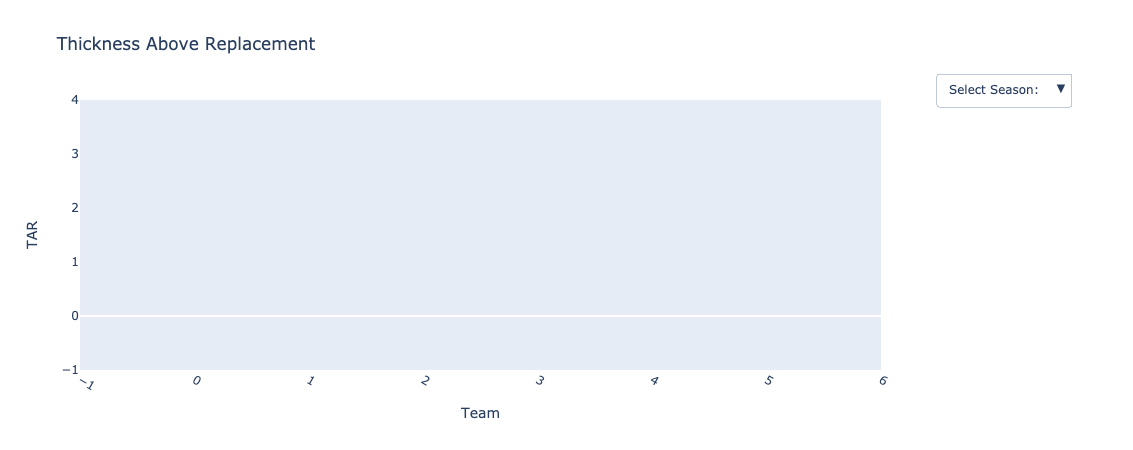

In [92]:
fig = go.Figure()
season_lst=set(team_tar['Season'])
season_lst = sorted(season_lst)
buttons = [{"label": "Select Season: ", "method": "update", "args": [{'visible': [False for sn in season_lst]}]}]

for season in season_lst:
    season_filt=(team_tar['Season']==season)
    trace=go.Bar(
            x=team_tar.loc[season_filt,'Team'], 
            y=team_tar.loc[season_filt,'TAR'],
            visible=False
        )
    
    fig.add_trace(trace)
    
    btnx = {"label": season, 'method': 'update',
            "args": [{'visible': [True if season == seasonx else False for seasonx in season_lst]}]}
    
    buttons.append(btnx)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            pad={"r": 50, "t": 0},
            xanchor="right", x=1.3, 
            yanchor="top", y=1.10,
        )
    ]
)

fig.update_layout(title_text='Thickness Above Replacement', autosize=True)
fig.update_xaxes(showgrid=False, tickangle=30, title='Team')
fig.update_yaxes(showgrid=False, title='TAR')
    
fig.show()